In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor 
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import pmdarima as pm
import lightgbm as lgb
import time
from prophet import Prophet
from statsmodels.tools.sm_exceptions import ConvergenceWarning


#pd.set_option('display.max_rows', 100)
#pd.set_option('display.max_columns', None)

2024-10-07 18:44:01.726021: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 18:44:01.773034: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 18:44:01.834307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 18:44:01.904291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 18:44:01.925264: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 18:44:02.010520: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Probably need to change this if your on MAC
spark = (
    SparkSession.builder.appName("Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '16g')
    .config('spark.executor.memory', '16g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/10/07 18:44:07 WARN Utils: Your hostname, Andy-PC resolves to a loopback address: 127.0.1.1; using 172.28.56.237 instead (on interface eth0)
24/10/07 18:44:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/07 18:44:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/07 18:44:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
full_transaction = spark.read.parquet("../data/curated/transactions.parquet")
full_transaction = full_transaction.drop("order_time")
full_transaction.show()

24/10/07 18:44:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+----+--------+--------------+------------+-------+-----------+------------------+--------------------+-------------+---------------+-----+------+------------------+--------------------+--------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+------------------+-----------+------------+--------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|consumer_name|        address|state|gender| fraud_probability|       merchant_name|                tags|type|take_rate|merchant_fraud_probability|AREASQKM21|   SHAPE_Leng|    SHAPE_Area|               lon|                lat|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M|Tot_P|Tot_F|  expected_revenue|day_of_week|da

In [4]:
full_transaction.show()

+-----+----+--------+--------------+------------+-------+-----------+------------------+--------------------+-------------+---------------+-----+------+------------------+--------------------+--------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+------------------+-----------+------------+--------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|consumer_name|        address|state|gender| fraud_probability|       merchant_name|                tags|type|take_rate|merchant_fraud_probability|AREASQKM21|   SHAPE_Leng|    SHAPE_Area|               lon|                lat|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M|Tot_P|Tot_F|  expected_revenue|day_of_week|da

In [5]:
full_transaction.select("tags").distinct().show(50,truncate = False)

+----------------------------------------------------------------+
|tags                                                            |
+----------------------------------------------------------------+
|books, periodicals, newspapers                                  |
|shoe                                                            |
|gift, card, novelty, souvenir                                   |
|watch, clock, jewelry repair                                    |
|art dealers, galleries                                          |
|digital goods, books, movies, music                             |
|jewelry, watch, clock, silverware                               |
|lawn, garden supply outlets, including nurseries                |
|opticians, optical goods, eyeglasses                            |
|computers, computer peripheral equipment, software              |
|bicycle,                                                        |
|hobby, toy, game                                             

In [6]:
pandas_transactions = pd.read_parquet("../data/curated/transactions.parquet")
pandas_transactions['order_datetime'] = pd.to_datetime(pandas_transactions['order_datetime'])

In [8]:
df = pandas_transactions.groupby(['merchant_abn', 'tags', 'take_rate', 'type']).agg({
    'dollar_value': 'sum',
    'order_id': 'count',
    'merchant_fraud_probability': 'mean',
    'fraud_probability': 'mean',
    'Median_tot_fam_inc_weekly': 'mean',
    'seasonal_sales': 'mean',
    'original_sales': 'mean',
    'Average_household_size': 'mean',
    'consumer_id': pd.Series.nunique,
    'expected_revenue': 'mean',
    'order_datetime': pd.Series.nunique
}).reset_index()


df.rename(columns={
    'dollar_value': 'Total Revenue',
    'order_id': 'Total Sales',
    'merchant_fraud_probability': 'Merchant Fraud',
    'fraud_probability': 'Consumer Fraud',
    'Median_tot_fam_inc_weekly': 'Median Family Income',
    'Average_household_size': 'Average Household Size',
    'consumer_id': 'Unique Customers',
    'expected_revenue': 'Average Expected Revenue',
    'order_datetime': 'Days with Sales'
}, inplace=True)


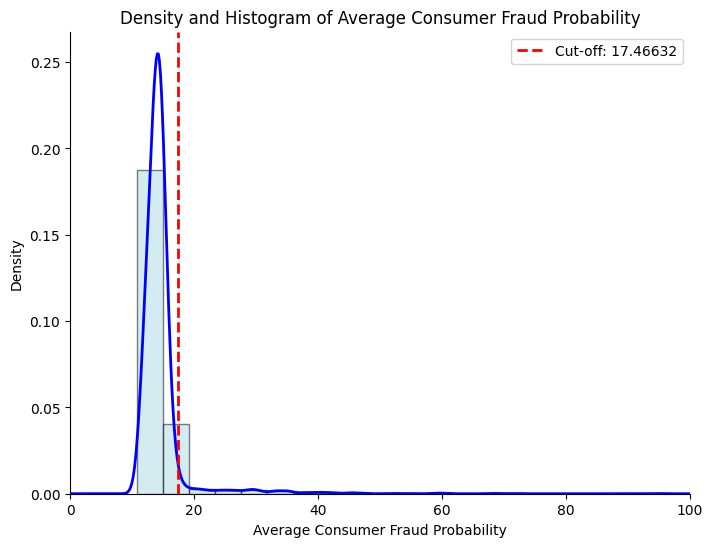

In [10]:
plt.figure(figsize=(8, 6))

df['Consumer Fraud'].plot(kind='hist', bins=20, color='lightblue', edgecolor='black', alpha=0.5, density=True)

df['Consumer Fraud'].plot(kind='density', color='blue', linewidth=2)

plt.xlim(0, 100)

cut_off_value = 17.46632
cutoff_line = plt.axvline(cut_off_value, color='red', linestyle='--', linewidth=2)

plt.xlabel('Average Consumer Fraud Probability')
plt.title('Density and Histogram of Average Consumer Fraud Probability')

plt.legend([cutoff_line], ['Cut-off: 17.46632'])

plt.gca().set_facecolor('none')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gcf().set_facecolor('none')
plt.savefig("density_histogram_transparent.png", transparent=True)
plt.show()


In [8]:
average_merchant_fraud = pandas_transactions.groupby('merchant_abn')['merchant_fraud_probability'].mean().reset_index()
high_merchant_fraud = average_merchant_fraud[average_merchant_fraud['merchant_fraud_probability'] > 51.12865]
df = df[~df['merchant_abn'].isin(high_merchant_fraud["merchant_abn"])]

average_consumer_fraud = pandas_transactions.groupby('merchant_abn')['fraud_probability'].mean().reset_index()
high_consumer_fraud = average_consumer_fraud[average_consumer_fraud['fraud_probability'] > 17.46632]
df = df[~df['merchant_abn'].isin(high_consumer_fraud["merchant_abn"])]

low_sales = df[df['Days with Sales'] < 181]
approved_merchants = df[~df['merchant_abn'].isin(low_sales["merchant_abn"])]


In [9]:
approved_merchants

,merchant_abn,tags,take_rate,type,Total Revenue,Total Sales,Merchant Fraud,Consumer Fraud,Median Family Income,seasonal_sales,original_sales,Average Household Size,Unique Customers,Average Expected Revenue,Days with Sales
1,10142254217,"cable, satellite, other pay television, radio",4.22,b,9.817670e+04,2544,28.504427,15.190879,1985.963050,6513.200039,6506.612186,2.460102,2389,116.434861,592
3,10187291046,"watch, clock, jewelry repair",3.29,b,3.387071e+04,292,41.524660,14.653650,1956.613014,6344.437329,6357.072603,2.452740,291,221.953325,228
4,10192359162,"music, musical instruments, pianos, sheet music",6.33,a,1.486921e+05,323,28.696554,13.982313,2048.272446,6451.810836,6411.728483,2.454489,321,2060.105342,246
5,10206519221,"gift, card, novelty, souvenir",6.34,a,3.040199e+05,8132,30.574287,14.880176,1967.801279,6463.688773,6476.468667,2.452988,6652,164.556583,606
6,10255988167,"computers, computer peripheral equipment, soft...",4.32,b,2.665801e+05,689,30.019225,13.736375,1957.566038,6682.321626,6688.567344,2.449347,676,1169.689261,406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,99845294286,"hobby, toy, game",5.73,a,1.177857e+06,677,35.026848,12.355737,1977.184638,6594.222304,6596.465140,2.482127,673,6499.220416,411
4019,99861963809,"cable, satellite, other pay television, radio",2.87,c,3.007120e+04,251,28.504479,15.182824,1962.788845,6629.782869,6633.500398,2.423506,249,245.831629,207
4020,99904689266,"digital goods, books, movies, music",6.65,a,5.089673e+05,4821,28.582818,14.911428,1969.685335,6472.294275,6462.422361,2.457291,4263,501.458803,606
4021,99938978285,"opticians, optical goods, eyeglasses",4.50,b,4.365202e+05,14536,28.559932,13.519573,1973.965327,6505.800076,6504.148266,2.457801,10338,96.506330,606


In [10]:
approved_merchants['merchant_abn'].nunique()

2120

In [11]:
df = pandas_transactions.groupby(['merchant_abn', 'order_datetime']).agg({
    'dollar_value': 'sum',  
    'fraud_probability': 'mean',  
    'merchant_fraud_probability': 'mean',  
    'take_rate': 'first', 
    'Average_household_size': 'mean',  
    'Median_tot_fam_inc_weekly': 'mean',
    'Median_tot_hhd_inc_weekly': 'mean',
}).reset_index()
df['expected_revenue'] = (
    df['dollar_value']
    * (1.0 - df['merchant_fraud_probability'] / 100.0)
    * (1.0 - df['fraud_probability'] / 100.0)
    * df['take_rate'] / 100.0
)

In [12]:
df["merchant_abn"].unique()

array(['10023283211', '10142254217', '10165489824', ..., '99976658299',
       '99987905597', '99990536339'], dtype=object)

In [13]:
df = df[~df['merchant_abn'].isin(approved_merchants["merchant_abn"].unique())]

In [14]:
df['day_of_week'] = df['order_datetime'].dt.dayofweek
df['month'] = df['order_datetime'].dt.month
df

,merchant_abn,order_datetime,dollar_value,fraud_probability,merchant_fraud_probability,take_rate,Average_household_size,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly,expected_revenue,day_of_week,month
0,10023283211,2021-02-28,701.566638,13.233968,64.593796,0.18,2.500,2104.333333,1773.333333,0.387945,6,2
1,10023283211,2021-03-01,384.996065,14.347222,63.555073,0.18,2.150,1394.000000,1091.000000,0.216325,0,3
2,10023283211,2021-03-02,869.072130,11.724605,64.548027,0.18,2.300,1956.750000,1510.000000,0.489563,1,3
3,10023283211,2021-03-03,176.838337,11.066055,57.830934,0.18,2.700,1472.000000,1334.000000,0.119374,2,3
4,10023283211,2021-03-04,894.742970,14.421158,58.384564,0.18,2.525,1652.500000,1457.500000,0.573577,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1204468,99990536339,2022-05-17,715.033569,13.049967,57.695334,0.18,2.400,1292.000000,941.000000,0.473431,1,5
1204469,99990536339,2022-08-05,356.950927,13.177599,67.493754,0.18,2.700,2263.000000,1935.000000,0.181334,4,8
1204470,99990536339,2022-08-31,528.370810,13.100574,67.491713,0.18,2.400,3778.000000,2710.000000,0.268672,2,8
1204471,99990536339,2022-09-14,586.143138,13.246176,28.690204,0.18,2.400,1792.000000,1412.000000,0.652701,2,9


/home/ache8119/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
XGBoost MAE: 0.24768436747472808, RMSE: 0.31656854885900093, MAPE: 102.06873220872093%


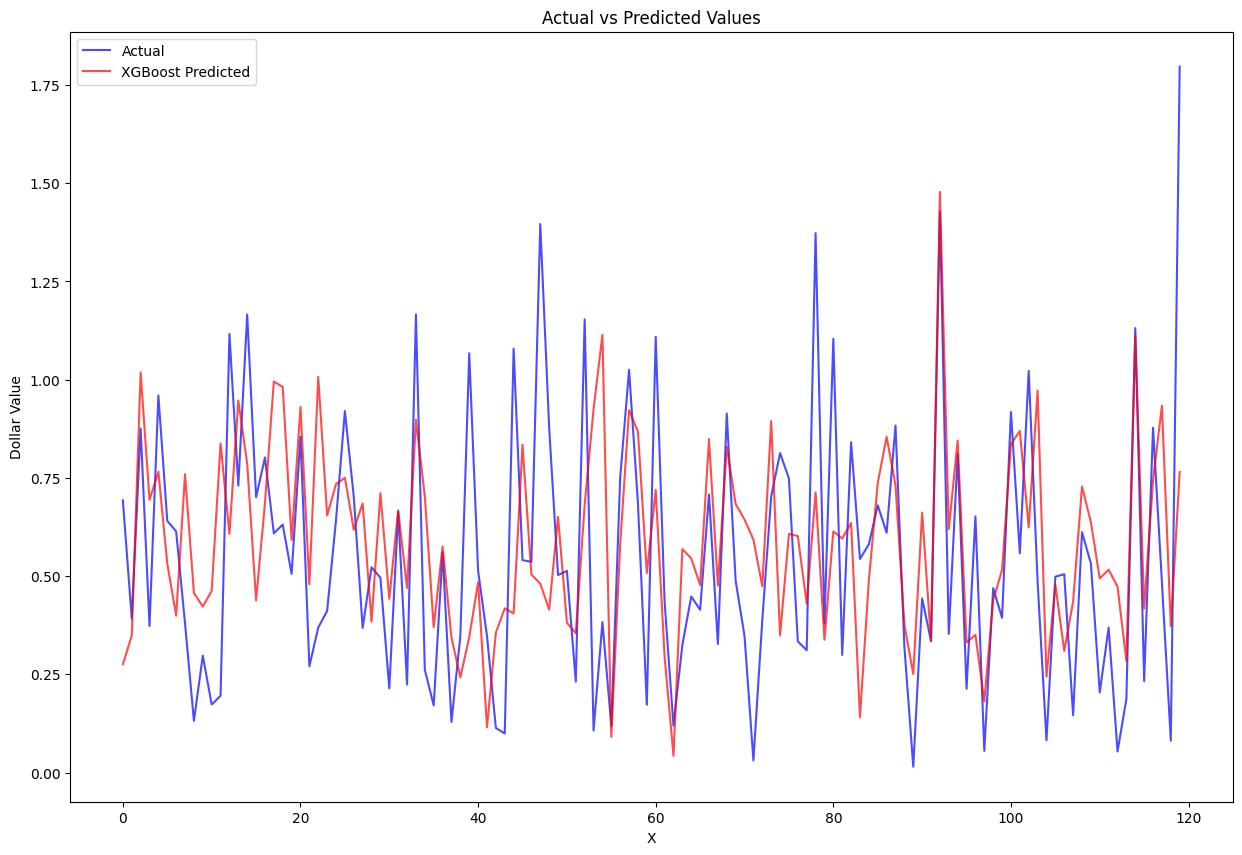

In [15]:
test = df[df['merchant_abn'] == "10023283211"]

target = 'expected_revenue'
features = ['day_of_week', 'month', 'fraud_probability', 'merchant_fraud_probability', 
            'Average_household_size', 'Median_tot_fam_inc_weekly', 'Median_tot_hhd_inc_weekly', 'take_rate']


pandas_df = test[features + [target]]
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5]
}

X = pandas_df[features]
y = pandas_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)
grid_search = GridSearchCV(estimator=xgbr, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)


y_pred_xgb = xgbr.predict(X_test)


mae_1 = np.mean(np.abs(y_test - y_pred_xgb))
rmse_1= np.sqrt(np.mean((y_test - y_pred_xgb) ** 2))
mape_1 = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
print(f"XGBoost MAE: {mae_1}, RMSE: {rmse_1}, MAPE: {mape_1}%")


plt.figure(figsize=(15, 10))
plt.plot(y_test.values, label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred_xgb, label='XGBoost Predicted', color='red', alpha=0.7)
plt.xlabel('X')
plt.ylabel('Dollar Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [16]:
# Initialize lists to store metrics for each merchant
overall_metrics = []
target = 'expected_revenue'
features = ['day_of_week', 'month', 'fraud_probability', 'merchant_fraud_probability', 
            'Average_household_size', 'Median_tot_fam_inc_weekly', 'Median_tot_hhd_inc_weekly', 'take_rate']
count = 0

for merchant in df['merchant_abn'].unique():
    test = df[df['merchant_abn'] == merchant]
    
    pandas_df = test[features + [target]]
    X = pandas_df[features]
    y = pandas_df[target]
    if len(X) > 1:  
   
        count +=1 
        print(count)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        xgbr = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.6)

        xgbr.fit(X_train, y_train)
        y_pred_xgb = xgbr.predict(X_test)
        

        mae_1 = np.mean(np.abs(y_test - y_pred_xgb))
        rmse_1= np.sqrt(np.mean((y_test - y_pred_xgb) ** 2))
        mape_1 = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
        
        overall_metrics.append({
            'merchant_abn': merchant,
            'XGBoost_MAE': mae_1,
            'XGBoost_RMSE': rmse_1,
            'XGBoost_MAPE': mape_1,

        })
    else:
        print(f"Skipping merchant {merchant} due to insufficient samples.")

metrics_df = pd.DataFrame(overall_metrics)

1
2
3
4
5
6
Skipping merchant 10404542215 due to insufficient samples.
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
2

In [18]:
average_metrics = metrics_df[['XGBoost_MAE', 'XGBoost_RMSE', 'XGBoost_MAPE',
                              ]].mean()

print(average_metrics)


XGBoost_MAE      17.977533
XGBoost_RMSE     21.629788
XGBoost_MAPE    189.030838
dtype: float64


In [19]:
pandas_transactions = pd.read_parquet("../data/curated/transactions.parquet")

In [7]:
pandas_transactions['order_datetime'] = pd.to_datetime(pandas_transactions['order_datetime'])

df_grouped = pandas_transactions.groupby(['merchant_abn', 'order_datetime']).agg({
    'dollar_value': 'sum',  
    'fraud_probability': 'mean',  
    'merchant_fraud_probability': 'mean',  
    'take_rate': 'first', 
    'Average_household_size': 'mean',  
    'Median_tot_fam_inc_weekly': 'mean',
    'Median_tot_hhd_inc_weekly': 'mean',
}).reset_index()

df_grouped.reset_index(inplace=True)
df_grouped['order_datetime'] = pd.to_datetime(df_grouped['order_datetime'])
#date_range = pd.date_range(start='2021-02-28', end='2022-10-26', freq='D')
#df_grouped = df_grouped.groupby('merchant_abn').apply(lambda x: x.set_index('order_datetime'))
#df_grouped = df_grouped.fillna(0)
df_grouped

,index,merchant_abn,order_datetime,dollar_value,fraud_probability,merchant_fraud_probability,take_rate,Average_household_size,Median_tot_fam_inc_weekly,Median_tot_hhd_inc_weekly
0,0,10023283211,2021-02-28,701.566638,13.233968,64.593796,0.18,2.500,2104.333333,1773.333333
1,1,10023283211,2021-03-01,384.996065,14.347222,63.555073,0.18,2.150,1394.000000,1091.000000
2,2,10023283211,2021-03-02,869.072130,11.724605,64.548027,0.18,2.300,1956.750000,1510.000000
3,3,10023283211,2021-03-03,176.838337,11.066055,57.830934,0.18,2.700,1472.000000,1334.000000
4,4,10023283211,2021-03-04,894.742970,14.421158,58.384564,0.18,2.525,1652.500000,1457.500000
...,...,...,...,...,...,...,...,...,...,...
1204468,1204468,99990536339,2022-05-17,715.033569,13.049967,57.695334,0.18,2.400,1292.000000,941.000000
1204469,1204469,99990536339,2022-08-05,356.950927,13.177599,67.493754,0.18,2.700,2263.000000,1935.000000
1204470,1204470,99990536339,2022-08-31,528.370810,13.100574,67.491713,0.18,2.400,3778.000000,2710.000000
1204471,1204471,99990536339,2022-09-14,586.143138,13.246176,28.690204,0.18,2.400,1792.000000,1412.000000


14:13:33 - cmdstanpy - INFO - Chain [1] start processing
14:13:33 - cmdstanpy - INFO - Chain [1] done processing


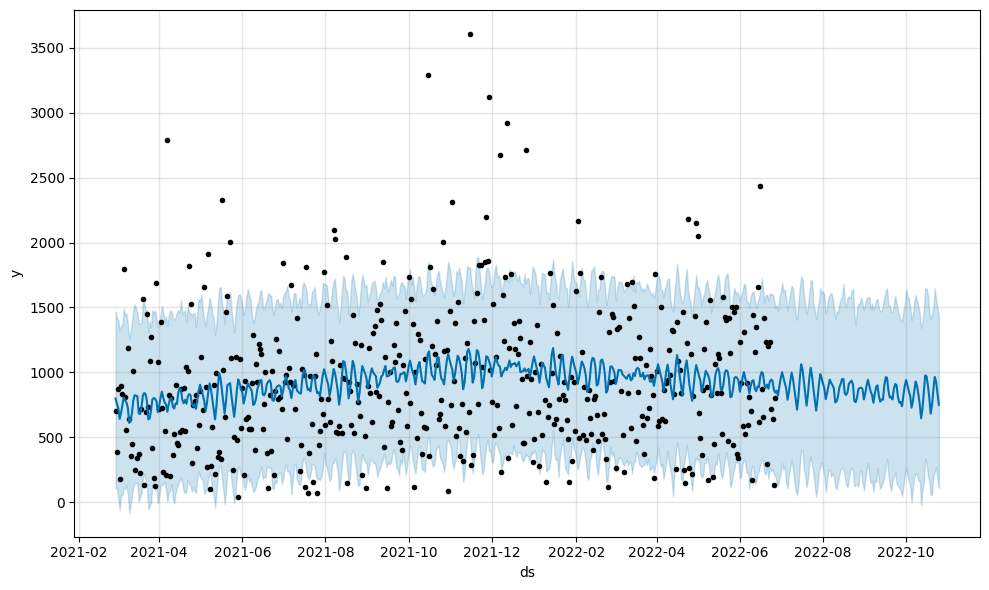

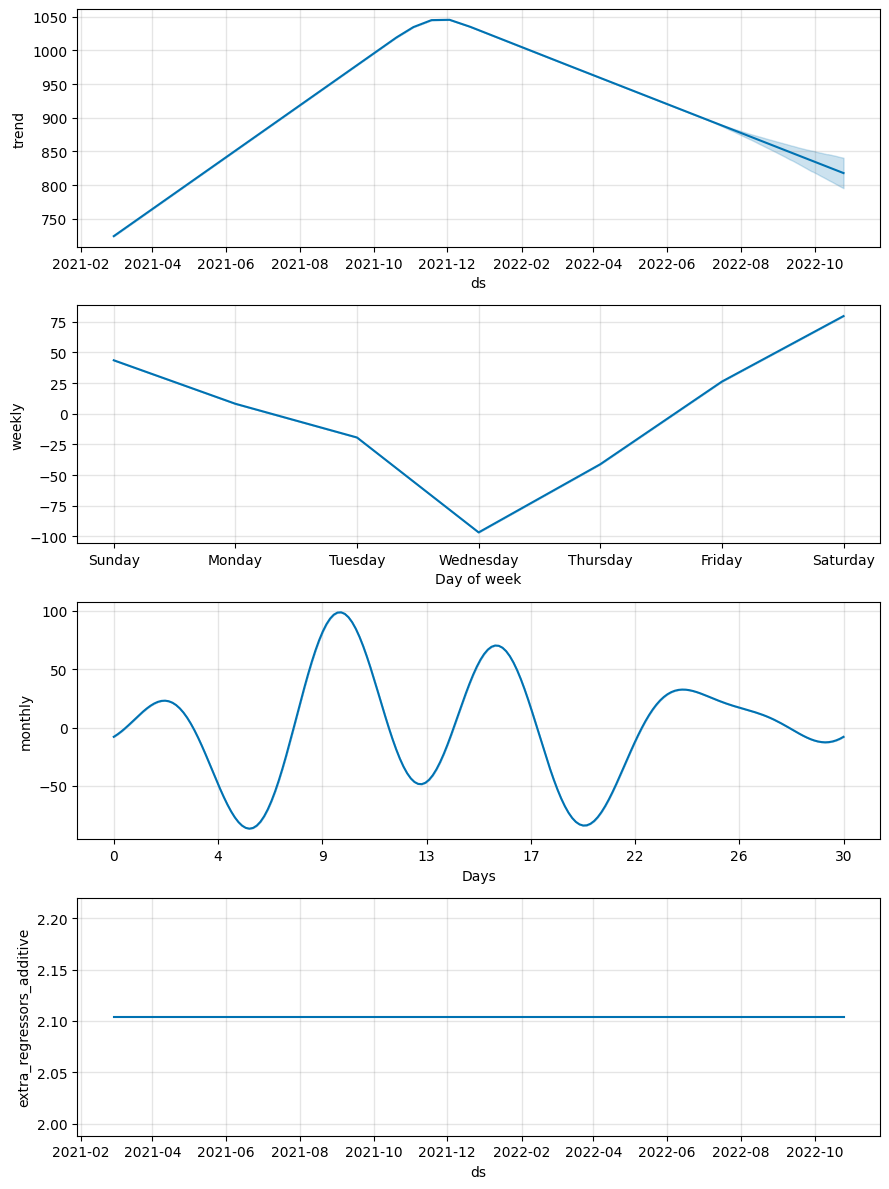

In [8]:
df = pd.read_csv('your_data.csv')

df['order_datetime'] = pd.to_datetime(df['order_datetime'])


df['day_of_week'] = df['order_datetime'].dt.dayofweek
df['month'] = df['order_datetime'].dt.month

target = 'dollar_value'
features = ['day_of_week', 'month', 'fraud_probability', 'merchant_fraud_probability', 
            'Average_household_size', 'Median_tot_fam_inc_weekly', 'Median_tot_hhd_inc_weekly', 'take_rate']

df.dropna(subset=features + [target], inplace=True)


X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(gbr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_gbr = grid_search.best_estimator_

y_pred = best_gbr.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Dollar Value')
plt.title('Actual vs Predicted Values - Gradient Boosting')
plt.legend()
plt.show()

In [ ]:
from joblib import Parallel, delayed
import traceback

def process_merchant(merchant):
    try:

        test = df_grouped[df_grouped['merchant_abn'] == merchant]

        test.reset_index(drop=True, inplace=True)
        test = test.reindex(date_range)
        test.fillna(0,inplace = True)
        test = test.infer_objects(copy=False)

        if merchant == "0":
            return None
    
        exog = test[['fraud_probability', 'merchant_fraud_probability', 'Average_household_size', 
                     'Median_tot_fam_inc_weekly', 'Median_tot_hhd_inc_weekly', 'take_rate']]


        scaler = StandardScaler()
        exog = scaler.fit_transform(exog)

        if len(test) < 100:
            model = ARIMA(test['dollar_value'], order=(1, 1, 1))
        else:
            model = SARIMAX(test['dollar_value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=exog)

        results = model.fit(maxiter=200, disp=False)

        rmse = np.sqrt(mean_squared_error(test['dollar_value'], results.fittedvalues))
        aic = results.aic


        return {'merchant_abn': merchant, 'RMSE': rmse, 'AIC': aic}

    except Exception as e:
        print(f"Error processing merchant {merchant}: {e}")
        traceback.print_exc()
        return None

results = Parallel(n_jobs=4)(delayed(process_merchant)(merchant) for merchant in df_grouped['merchant_abn'].unique())

metrics_df = pd.DataFrame([r for r in results if r is not None])

print(metrics_df)


In [ ]:
test = df_grouped[df_grouped['merchant_abn'] == '99990536339']                 
test = test.fillna(0)

exog = test[['fraud_probability', 'merchant_fraud_probability', 'Average_household_size', 
           'Median_tot_fam_inc_weekly', 'Median_tot_hhd_inc_weekly', 'take_rate']]

if len(test)<100:
    sarimax_model = ARIMA(test['dollar_value'], order=(1, 1, 1))
else:
    sarimax_model = SARIMAX(test["dollar_value"], order=(3, 1, 0), seasonal_order=(3, 1, 0, 12), exog=exog)
sarimax_results = sarimax_model.fit()

print(sarimax_results.summary())

forecast_steps = 12
forecast = sarimax_results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
residuals = sarimax_results.resid
residuals_reset = residuals.reset_index(level=0, drop=True)

plt.figure(figsize=(15, 6))
plt.plot(residuals_reset)
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

print(residuals.describe())


In [ ]:
computer_transactions = full_transaction.filter(F.col("tags") == "computer programming, data processing, integrated systems design").toPandas()
bicycle_transactions = full_transaction.filter(F.col("tags") == "bicycle").toPandas()
artsupply_transactions = full_transaction.filter(F.col("tags") == "artist supply, craft").toPandas()

In [8]:
def ranking_algorithm(df):
    merchant_aggregated = df.groupby("merchant_abn").agg({
        "dollar_value": "sum",
        "merchant_fraud_probability": "mean",  
        "fraud_probability": "mean",  
        "order_id": "count",  
        "consumer_id": pd.Series.nunique,
        "postcode": pd.Series.nunique, 
        "Median_tot_hhd_inc_weekly": "mean",  
        "Average_household_size": "mean", 
    })
    
    merchant_aggregated.columns = ["total_revenue", "merchant_fraud_probability", "consumer_fraud_probability", 
                            "order_count", "unique_consumers", "postcode_count", "household_income", "household_size"]

    merchant_aggregated["revenue_score"] = (merchant_aggregated["total_revenue"] - merchant_aggregated["total_revenue"].min())/(merchant_aggregated["total_revenue"].max() - merchant_aggregated["total_revenue"].min())

    merchant_aggregated["fraud_probability_score"] = 1 - (0.005 * merchant_aggregated["merchant_fraud_probability"] + 0.005 * merchant_aggregated["consumer_fraud_probability"])

    merchant_aggregated["market_potential_score"] = (merchant_aggregated["household_income"]/merchant_aggregated["household_size"]) / 2
    merchant_aggregated["market_potential_score"] = (merchant_aggregated["market_potential_score"] - merchant_aggregated["market_potential_score"].min())/(merchant_aggregated["market_potential_score"].max() - merchant_aggregated["market_potential_score"].min())

    order_score = (merchant_aggregated["order_count"] - merchant_aggregated["order_count"].min())/(merchant_aggregated["order_count"].max() - merchant_aggregated["order_count"].min())
    unique_consumers_score = (merchant_aggregated["unique_consumers"] - merchant_aggregated["unique_consumers"].min())/(merchant_aggregated["unique_consumers"].max() - merchant_aggregated["unique_consumers"].min())
    postcode_score = (merchant_aggregated["postcode_count"] - merchant_aggregated["postcode_count"].min())/(merchant_aggregated["postcode_count"].max() - merchant_aggregated["postcode_count"].min())

    merchant_aggregated["customer_quality_score"] = (order_score + unique_consumers_score + postcode_score) / 3
    merchant_aggregated["customer_quality_score"] = (merchant_aggregated["customer_quality_score"] - merchant_aggregated["customer_quality_score"].min())/(merchant_aggregated["customer_quality_score"].max() - merchant_aggregated["customer_quality_score"].min())

    merchant_aggregated["composite_score"] = (0.5 * merchant_aggregated["revenue_score"] + 
                                              0.2 * merchant_aggregated["fraud_probability_score"] + 
                                              0.2 * merchant_aggregated["market_potential_score"] + 
                                              0.1 * merchant_aggregated["customer_quality_score"])

    merchant_aggregated["rank"] = merchant_aggregated["composite_score"].rank(ascending=False)

    results = merchant_aggregated.sort_values(by="composite_score", ascending=False)

    return results

In [ ]:
overall_ranks = ranking_algorithm(pandas_transactions)
overall_ranks.head(100)

In [10]:
computer_ranks = ranking_algorithm(computer_transactions)
bicycle_ranks = ranking_algorithm(bicycle_transactions)
artsupply_ranks = ranking_algorithm(artsupply_transactions)

In [ ]:
computer_ranks.head(10)

In [ ]:
bicycle_ranks.head(10)

In [ ]:
artsupply_ranks.head(10)

Ignore everything below this point.

In [ ]:
aggregated_transactions= full_transaction.groupBy('merchant_abn').agg((F.sum('dollar_value')).alias('dollar_value'),
                                                    F.sum(F.when(F.col("gender") == "Male", 1)).alias("Male_count"),
                                                    F.sum(F.when(F.col("gender") == "Female", 1)).alias("Female_count"),
                                                    F.sum(F.when(F.col("gender") == "Undisclosed", 1)).alias("Undisclosed_count"),
                                                    F.sum(F.when(F.col("state") == "VIC", 1)).alias("VIC_count"),
                                                    F.sum(F.when(F.col("state") == "WA", 1)).alias("WA_count"),
                                                    F.sum(F.when(F.col("state") == "NSW", 1)).alias("NSW_count"),
                                                    F.sum(F.when(F.col("state") == "SA", 1)).alias("SA_count"),
                                                    F.sum(F.when(F.col("state") == "QLD", 1)).alias("QLD_count"),
                                                    F.sum(F.when(F.col("state") == "TAS", 1)).alias("TAS_count"),
                                                    F.sum(F.when(F.col("state") == "NT", 1)).alias("NT_count"),
                                                    F.sum(F.when(F.col("state") == "ACT", 1)).alias("ACT_count"),
                                                    F.sum(F.when(F.col("type") == "a", 1)).alias("a_count"),
                                                    F.sum(F.when(F.col("type") == "b", 1)).alias("b_count"),
                                                    F.sum(F.when(F.col("type") == "c", 1)).alias("c_count"),
                                                    F.sum(F.when(F.col("type") == "d", 1)).alias("d_count"),
                                                    F.sum(F.when(F.col("type") == "e", 1)).alias("e_count"),
                                                    F.first("tags").alias("tags"),
                                                    F.first("take_rate").alias("take_rate")
                                                    )

aggregated_transactions = aggregated_transactions.fillna(0)
aggregated_transactions = aggregated_transactions.withColumn("revenue", F.col("dollar_value") * (F.col("take_rate")))
aggregated_transactions.show()

In [ ]:
full_transaction.select("tags").distinct().show(100,truncate = False)

In [ ]:
aggregated_pandas = aggregated_transactions.toPandas()

columns= ['merchant_abn',
 'Male_count',
 'Female_count',
 'Undisclosed_count',
 'VIC_count',
 'WA_count',
 'NSW_count',
 'SA_count',
 'QLD_count',
 'TAS_count',
 'NT_count',
 'ACT_count',
 'a_count',
 'b_count',
 'c_count',
 'd_count',
 'e_count']

numeric_columns= ['merchant_abn',
 'Male_count',
 'Female_count',
 'Undisclosed_count',
 'VIC_count',
 'WA_count',
 'NSW_count',
 'SA_count',
 'QLD_count',
 'TAS_count',
 'NT_count',
 'ACT_count',
 'a_count',
 'b_count',
 'c_count',
 'd_count',
 'e_count']

aggregated_pandas[numeric_columns] = aggregated_pandas[numeric_columns].apply(pd.to_numeric, errors='coerce')

X = aggregated_pandas[columns].values
y = aggregated_pandas["revenue"].values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) 
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


In [ ]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=128)

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()


In [ ]:
predictions = model.predict(X_test)

results = pd.DataFrame(X_test, columns=['merchant_abn',
 'Male_count',
 'Female_count',
 'Undisclosed_count',
 'VIC_count',
 'WA_count',
 'NSW_count',
 'SA_count',
 'QLD_count',
 'TAS_count',
 'NT_count',
 'ACT_count',
 'a_count',
 'b_count',
 'c_count',
 'd_count',
 'e_count'])

results['revenue'] = predictions

ranked_merchants = results.sort_values(by='revenue', ascending=False)
print(ranked_merchants)
predictions


In [ ]:
predictions = np.squeeze(predictions) 

comparison_df = pd.DataFrame({
    'y_test': y_test,
    'predictions': predictions,
    'difference': y_test - predictions
})

mae = np.mean(np.abs(comparison_df['difference']))
print(f"Mean Absolute Error: {mae}")